In [1]:
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\emotion_sentiment_dataset.csv")
df = df.drop(df.columns[0], axis = 1)
df = df.drop_duplicates()
df

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral
...,...,...
422740,i cry and feel a sense of loss when my patient...,neutral
422741,i feel like telling these horny devils to find...,neutral
422743,i feel very curious be why previous early dawn...,neutral
422744,i feel that becuase of the tyranical nature of...,neutral


In [4]:
print(df['text'][0])

i seriously hate one subject to death but now i feel reluctant to drop it


In [5]:
print(f"Unique emotions: {df['Emotion'].unique()}\n Number of unique emotions: {df['Emotion'].nunique()}")

Unique emotions: ['hate' 'neutral' 'anger' 'love' 'worry' 'relief' 'happiness' 'fun'
 'empty' 'enthusiasm' 'sadness' 'surprise' 'boredom']
 Number of unique emotions: 13


We need to convert our labels into numeric values so the model can work with them

In [6]:
df['Label'], Emotions = pd.factorize(df['Emotion'])
df['Label']

0         0
1         1
2         1
3         2
4         1
         ..
422740    1
422741    1
422743    1
422744    1
422745    1
Name: Label, Length: 393822, dtype: int64

In [7]:
X = df['text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

Before we can feed our inputs into the model, we need to convert them into a form the computer can read: numbers. Tensorflow has a tokenizer method built in, which essentially creates a dictionary of words from a series of texts.

Once we have all of our tokens, we can transform our lines of text into sequences of tokens which can be fed into the model.

In [8]:
tokenizer = Tokenizer(num_words = 60000, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_sequences[0]

[2, 3, 826, 4, 339, 130]

Our model expects a uniform input size. To accomplish this we pad the sequences with 0's so that each input is equal in size to our largest input.

In [9]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

Maximum sequence length (maxlen): 178


In [10]:
X_train_padded[0]

array([  2,   3, 826,   4, 339, 130,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])

In [11]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=np.max(X_train_padded)+1, output_dim=100,input_shape=(maxlen,)))
model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',
                kernel_regularizer=L1(0.01),
                activity_regularizer=L2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 100)          6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [13]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test_padded, y_test))

Epoch 1/5
9846/9846 [==============================] - 742s 74ms/step - loss: 0.6070 - accuracy: 0.8773 - val_loss: 0.3649 - val_accuracy: 0.9480
Epoch 2/5
9846/9846 [==============================] - 702s 71ms/step - loss: 0.3448 - accuracy: 0.9400 - val_loss: 0.2429 - val_accuracy: 0.9652
Epoch 3/5
9846/9846 [==============================] - 711s 72ms/step - loss: 0.3064 - accuracy: 0.9522 - val_loss: 0.2436 - val_accuracy: 0.9661
Epoch 4/5
9846/9846 [==============================] - 716s 73ms/step - loss: 0.2939 - accuracy: 0.9579 - val_loss: 0.2623 - val_accuracy: 0.9724
Epoch 5/5
9846/9846 [==============================] - 699s 71ms/step - loss: 0.2814 - accuracy: 0.9663 - val_loss: 0.2362 - val_accuracy: 0.9928


In [14]:
history_dict = history.history
json.dump(history_dict, open('LSTM_history','w'))

In [15]:
model.save('LSTM_Model.keras')

In [16]:
history = json.load(open(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\LSTM\history.json",'r'))

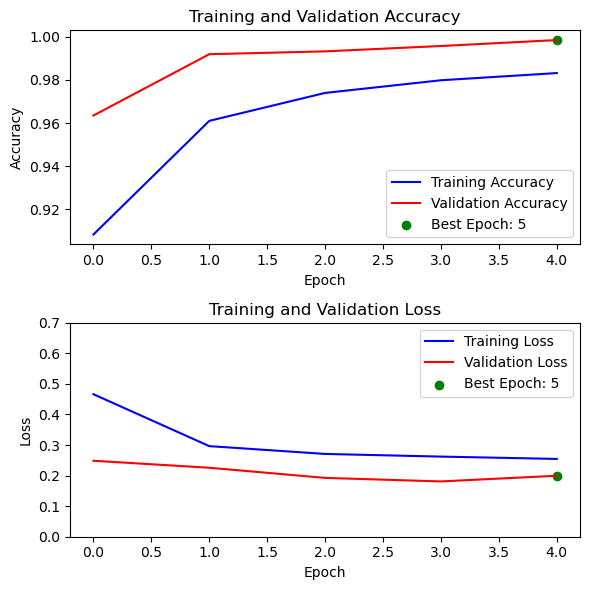

In [18]:
best_epoch = history['val_accuracy'].index(max(history['val_accuracy'])) + 1

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training and validation accuracy
axs[0].plot(history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history['loss'], label='Training Loss', color='blue')
axs[1].plot(history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_ylim([0,.7])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [9]:
model = tf.keras.models.load_model(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\LSTM\LSTM_Model.keras")

In [19]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2462/2462 [==============================] - 58s 23ms/step


In [20]:
print(classification_report(y_test,y_pred,labels = list(np.arange(13)),target_names = ['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness', 'fun',
 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'], zero_division = 0.0))

              precision    recall  f1-score   support

        hate       1.00      0.99      0.99      1206
     neutral       1.00      1.00      1.00     63386
       anger       1.00      0.99      0.99      1189
        love       1.00      0.99      1.00      3541
       worry       0.00      0.00      0.00       413
      relief       1.00      0.99      0.99      1606
   happiness       1.00      1.00      1.00      2621
         fun       0.97      0.99      0.98       946
       empty       1.00      0.97      0.99       534
  enthusiasm       1.00      0.99      1.00       867
     sadness       1.00      0.99      0.99      1768
    surprise       0.61      1.00      0.75       672
     boredom       0.00      0.00      0.00        16

    accuracy                           0.99     78765
   macro avg       0.81      0.84      0.82     78765
weighted avg       0.99      0.99      0.99     78765



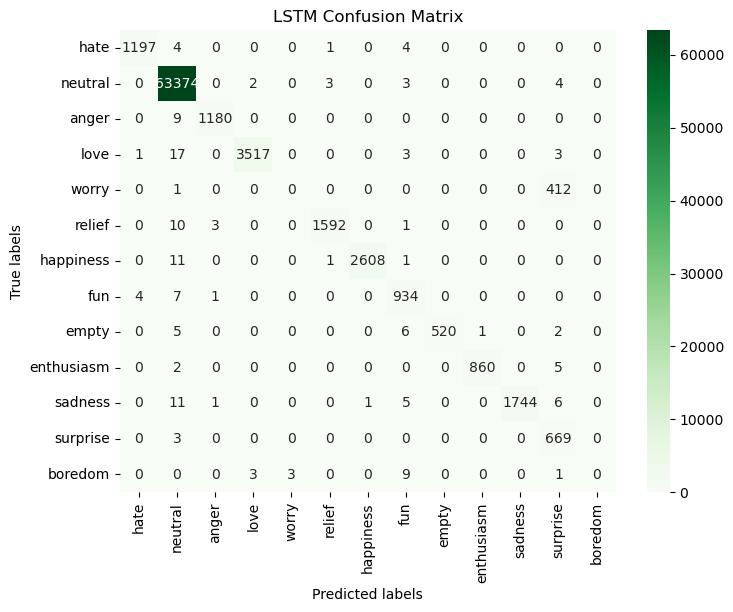

In [21]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt='d', cmap = 'Greens',
           xticklabels = ['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness', 'fun',
 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
           yticklabels = ['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness', 'fun',
 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom']) 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LSTM Confusion Matrix')
plt.show()

In [22]:
T_history = json.load(open(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\Transformer\transformer_history",'r'))

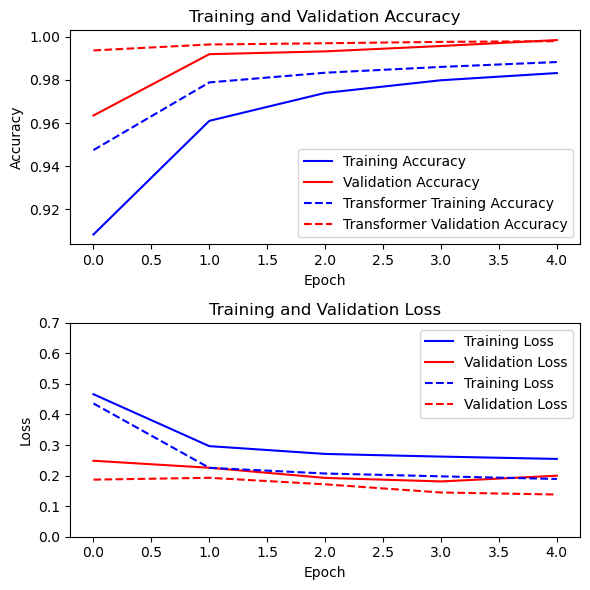

In [24]:
best_epoch = history['val_accuracy'].index(max(history['val_accuracy'])) + 1

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training and validation accuracy
axs[0].plot(history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].plot(T_history['accuracy'], label='Transformer Training Accuracy', color='blue', linestyle = 'dashed')
axs[0].plot(T_history['val_accuracy'], label='Transformer Validation Accuracy', color='red', linestyle = 'dashed')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history['loss'], label='Training Loss', color='blue')
axs[1].plot(history['val_loss'], label='Validation Loss', color='red')
axs[1].plot(T_history['loss'], label='Training Loss', color='blue', linestyle = 'dashed')
axs[1].plot(T_history['val_loss'], label='Validation Loss', color='red', linestyle = 'dashed')
axs[1].set_ylim([0,.7])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

### Generative Text

In [3]:
songs = pd.read_excel(r"English_Lyrics.xlsx")
songs.head()

,Unnamed: 0,Lyric
0,69,I feel so unsure\nAs I take your hand and lead...
1,86,"Don't let them fool, ya\nOr even try to school..."
2,88,"Baby, let's cruise, away from here\nDon't be c..."
3,111,"Know it sounds funny\nBut, I just can't stand ..."
4,140,You've got that look again\nThe one I hoped I ...


In [ ]:
songs_en = songs[songs.language == 'en']

In [ ]:
songs_en['Lyric'].to_excel("English_Lyrics.xlsx", sheet_name = 'Lyrics')

In [5]:
# select subset of songs cause I'm not Amazon
songs_en = songs[:250]

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(songs_en['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(songs_en['Lyric'].astype(str))

In [7]:
# Create n-gram sequences
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)

# Pre-padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [8]:
# Creating predictors and labels
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [9]:
model = Sequential() # Initialization
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dropout(0.1))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto')
history = model.fit(X, y, epochs=10, verbose=1, callbacks=[earlystop])

Epoch 1/10
2972/2972 [==============================] - 372s 123ms/step - loss: 5.6778 - accuracy: 0.0916
Epoch 2/10
2972/2972 [==============================] - 269s 90ms/step - loss: 4.5900 - accuracy: 0.1980
Epoch 3/10
2972/2972 [==============================] - 262s 88ms/step - loss: 3.8806 - accuracy: 0.2855
Epoch 4/10
2972/2972 [==============================] - 259s 87ms/step - loss: 3.3586 - accuracy: 0.3570
Epoch 5/10
2972/2972 [==============================] - 258s 87ms/step - loss: 2.9527 - accuracy: 0.4185
Epoch 6/10
2972/2972 [==============================] - 257s 86ms/step - loss: 2.6298 - accuracy: 0.4673
Epoch 7/10
2972/2972 [==============================] - 257s 86ms/step - loss: 2.3559 - accuracy: 0.5128
Epoch 8/10
2972/2972 [==============================] - 258s 87ms/step - loss: 2.1320 - accuracy: 0.5516
Epoch 9/10
2972/2972 [==============================] - 258s 87ms/step - loss: 1.9374 - accuracy: 0.5879
Epoch 10/10
2972/2972 [==============================]

In [15]:
model.save('LSTM_Gen_Model')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
history_dict = history.history
json.dump(history_dict, open('LSTM_Gen_history2','w'))

In [ ]:
del model
model = tf.keras.models.load_model(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\LSTM\LSTM_Gen_Model.keras")

In [10]:
def generate_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)
        choice = np.random.choice([1,2,3])
        # sort ascending and select from 3 highest probabilities
        predicted = np.argsort(predictions)[0][-choice]

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [11]:
seed_text = 'Lie'
generate_lyrics(seed_text, 20)

"Lie baby i know you want my baby baby i'm gonna be the only girl i see and you and i"

In [13]:
history_dict = history.history
json.dump(history_dict, open('LSTM_Gen_history','w'))

In [5]:
new_model = tf.keras.models.load_model(r"C:\Users\danfe\Downloads\LSTM_Gen_Model.keras")

OSError: Unable to synchronously open file (file signature not found)